## Importing Libraries

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Input, Activation, Dropout
from keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [50]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\Anyang
[nltk_data]     Wu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Anyang
[nltk_data]     Wu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

## Dataset 

In [4]:
df = pd.read_csv('../Dataset/train.csv')
df

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3
...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2
17303,ffddf1f,Technology has changed a lot of ways that we l...,4
17304,fff016d,If you don't like sitting around all day than ...,2
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1


### Scoring Criteria

The score indicates the quality of student-written argumentative essays, rated based on perspective, critical thinking, evidence, organization, language, and grammar/mechanics.

| Score | Description |
|-------|-------------|
| 6     | Clear mastery, few errors, outstanding critical thinking, appropriate evidence, well-organized, skilled language use. |
| 5     | Reasonable mastery, some errors, strong critical thinking, generally appropriate evidence, well-organized, good language use. |
| 4     | Adequate mastery, occasional lapses, competent critical thinking, adequate evidence, generally organized, fair language use. |
| 3     | Developing mastery, weaknesses, limited critical thinking, inconsistent evidence, some organization, fair language use. |
| 2     | Little mastery, serious flaws, weak critical thinking, insufficient evidence, poor organization, frequent errors. |
| 1     | Very little mastery, severe flaws, no viable point of view, disorganized, pervasive errors. |

## EDA (Exploratory Data Analysis)

In [8]:
# displaying basic information

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17307 entries, 0 to 17306
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   17307 non-null  object
 1   full_text  17307 non-null  object
 2   score      17307 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 405.8+ KB


In [10]:
# displaying basic information

df.describe()

,score
count,17307.000000
mean,2.948402
std,1.044899
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,6.000000


In [12]:
# checking for missing values

df.isnull().sum()

essay_id     0
full_text    0
score        0
dtype: int64

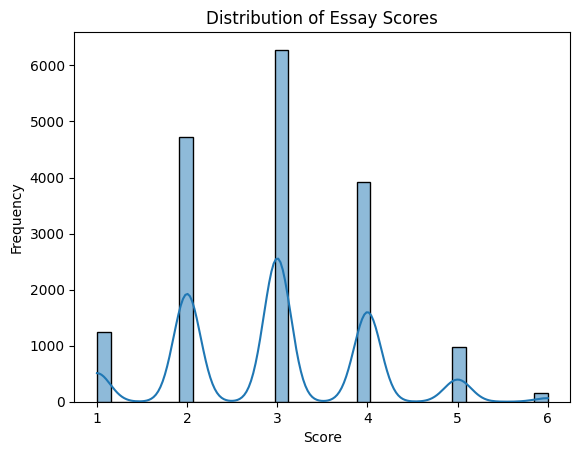

In [14]:
# Analyze the distribution of essay scores

sns.histplot(df['score'], kde=True)
plt.title('Distribution of Essay Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.savefig('../Images/Score Distribution.png')
plt.show()

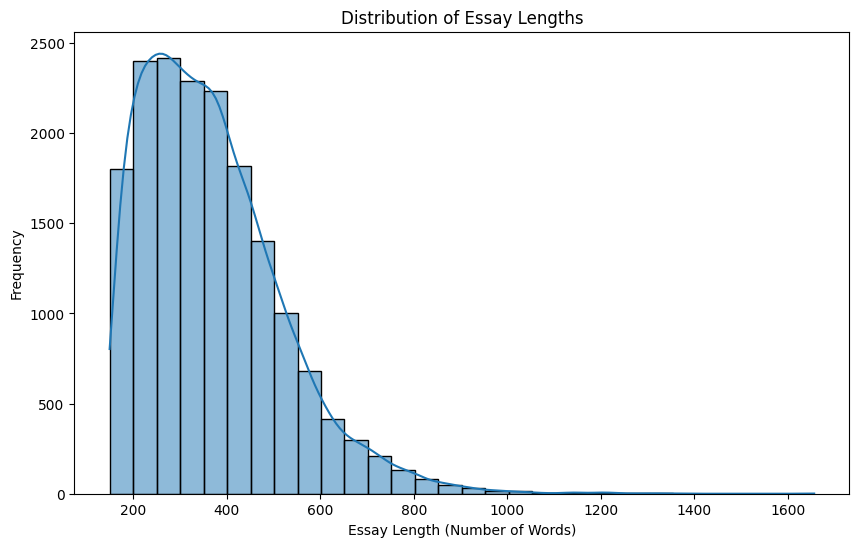

In [15]:
# Calculate the length of each essay
df['essay_length'] = df['full_text'].apply(lambda x: len(x.split()))

# Plot the distribution of essay lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['essay_length'], kde=True, bins=30)
plt.title('Distribution of Essay Lengths')
plt.xlabel('Essay Length (Number of Words)')
plt.ylabel('Frequency')
plt.savefig('../Images/Length Distribution.png')
plt.show()

## Data Preprocessing

In [44]:
stop_words = set(stopwords.words('english'))
def remove_stop_words(essay):
    word_tokens = word_tokenize(essay) 
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    return ' '.join(filtered_sentence)

In [52]:
def preprocess_text(essay):
    essay = re.sub(r'\d+', '', essay)
    essay = re.sub(r'[^\w\s]', '', essay)
    tokens = word_tokenize(essay.lower())
    return tokens

In [77]:
df['clean_essay'] = df['full_text'].apply(lambda x:remove_stop_words(x))

In [78]:
df['cleaned_essay'] = df['clean_essay'].apply(preprocess_text)

In [79]:
df['cleaned_essay'].head()

0    [many, people, car, live, the, thing, nt, know...
1    [i, scientist, nasa, discussing, face, mars, i...
2    [people, always, wish, technology, seen, movie...
3    [we, heard, venus, planet, without, almost, ox...
4    [dear, state, senator, this, letter, argue, fa...
Name: cleaned_essay, dtype: object

## LSTM Model

In [81]:
# Tokenize the text

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_essay'])
X = tokenizer.texts_to_sequences(df['cleaned_essay'])
X = pad_sequences(X, maxlen=200)
Y = df['score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [82]:
def model():
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    return model

In [83]:
model = model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          640000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 200, 128)          131584    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                        

In [84]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [107]:
history = model.fit(X_train ,y_train,batch_size=64, validation_split=0.2, epochs=15)

Epoch 1/15
174/174 [==============================] - 128s 737ms/step - loss: 0.7801 - mean_squared_error: 0.7801 - val_loss: 0.5528 - val_mean_squared_error: 0.5528
Epoch 2/15
174/174 [==============================] - 127s 733ms/step - loss: 0.6070 - mean_squared_error: 0.6070 - val_loss: 0.4932 - val_mean_squared_error: 0.4932
Epoch 3/15
174/174 [==============================] - 130s 747ms/step - loss: 0.5650 - mean_squared_error: 0.5650 - val_loss: 0.5265 - val_mean_squared_error: 0.5265
Epoch 4/15
174/174 [==============================] - 128s 734ms/step - loss: 0.5197 - mean_squared_error: 0.5197 - val_loss: 0.4787 - val_mean_squared_error: 0.4787
Epoch 5/15
174/174 [==============================] - 130s 747ms/step - loss: 0.4924 - mean_squared_error: 0.4924 - val_loss: 0.5185 - val_mean_squared_error: 0.5185
Epoch 6/15
174/174 [==============================] - 129s 742ms/step - loss: 0.4673 - mean_squared_error: 0.4673 - val_loss: 0.5786 - val_mean_squared_error: 0.5786
Epoc

In [108]:
# Evaluation with Quadratic Weighted Kappa

from sklearn.metrics import cohen_kappa_score
import numpy as np

# Predict using the trained model
y_pred = model.predict(X_test).flatten()
y_pred = np.rint(y_pred)  # Round predictions to nearest integer

# Calculate Quadratic Weighted Kappa
kappa_score = cohen_kappa_score(y_test, y_pred, weights='quadratic')
print(f'Quadratic Weighted Kappa: {kappa_score}')

Quadratic Weighted Kappa: 0.6701574116466059


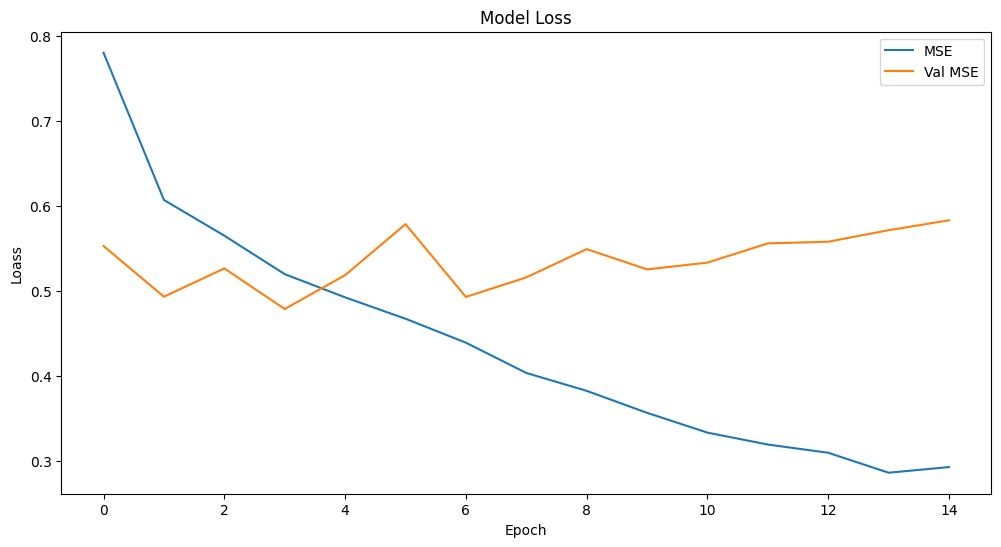

In [109]:
# Visualization of Training History

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loass')
plt.legend()
plt.savefig('../Images/LSTM Loss.png')
plt.show()

## GRU Model

In [111]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, SpatialDropout1D

# Define the GRU model
def model():
    model_gru = Sequential()
    model_gru.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
    model_gru.add(SpatialDropout1D(0.2))
    model_gru.add(GRU(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model_gru.add(GRU(64, dropout=0.2, recurrent_dropout=0.2))
    model_gru.add(Dense(32, activation='relu'))
    model_gru.add(Dropout(0.2))
    model_gru.add(Dense(1, activation='linear'))
    return model_gru

In [112]:
model_gru = model()
model_gru.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
model_gru.summary()

# Train the model
history_gru = model_gru.fit(X, Y, epochs=20, batch_size=64, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 128)          640000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 200, 128)         0         
 lDropout1D)                                                     
                                                                 
 gru (GRU)                   (None, 200, 128)          99072     
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                      

In [113]:
# Evaluation with Quadratic Weighted Kappa

from sklearn.metrics import cohen_kappa_score
import numpy as np

# Predict using the trained model
y_pred_gru = model_gru.predict(X_test).flatten()
y_pred_gru = np.rint(y_pred_gru)  # Round predictions to nearest integer

# Calculate Quadratic Weighted Kappa
kappa_score_gru = cohen_kappa_score(y_test, y_pred_gru, weights='quadratic')
print(f'Quadratic Weighted Kappa: {kappa_score_gru}')

Quadratic Weighted Kappa: 0.9016405397878643


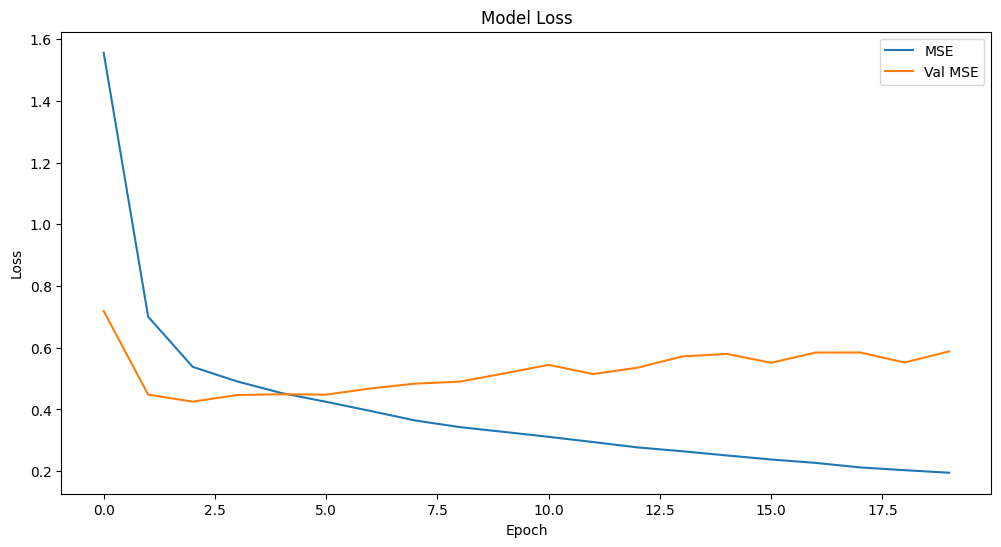

In [114]:
# Visualization of Training History

plt.figure(figsize=(12, 6))
plt.plot(history_gru.history['loss'], label='MSE')
plt.plot(history_gru.history['val_loss'], label='Val MSE')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../Images/GRU Loss.png')
plt.show()

## CNN for Text

In [116]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, SpatialDropout1D

# Define the CNN model
def model():
    model_cnn = Sequential()
    model_cnn.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
    model_cnn.add(Conv1D(128, 5, activation='relu'))
    model_cnn.add(MaxPooling1D(5))
    model_cnn.add(Conv1D(64, 5, activation='relu'))
    model_cnn.add(GlobalMaxPooling1D())
    model_cnn.add(Dense(32, activation='relu'))
    model_cnn.add(Dropout(0.2))
    model_cnn.add(Dense(1, activation='linear'))
    return model_cnn

In [ ]:
model_cnn=model()
model_cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
model_cnn.summary()

# Train the model
history_cnn = model_cnn.fit(X, Y, epochs=20, batch_size=64, validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 128)          640000    
                                                                 
 conv1d (Conv1D)             (None, 196, 128)          82048     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 39, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 35, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 32)               

In [ ]:
# Evaluation with Quadratic Weighted Kappa

from sklearn.metrics import cohen_kappa_score
import numpy as np

# Predict using the trained model
y_pred_cnn = model_cnn.predict(X_test).flatten()
y_pred_cnn = np.rint(y_pred_cnn)  # Round predictions to nearest integer

# Calculate Quadratic Weighted Kappa
kappa_score_cnn = cohen_kappa_score(y_test, y_pred_cnn, weights='quadratic')
print(f'Quadratic Weighted Kappa (CNN): {kappa_score_cnn}')

In [ ]:
# Visualization of Training History

plt.figure(figsize=(12, 6))
plt.plot(history_cnn.history['loss'], label='MSE')
plt.plot(history_cnn.history['val_loss'], label='Val MSE')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../Images/CNN Loss.png')
plt.show()